**Necessary Imports**

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

**Helper function for evaluation metrics**

In [134]:
def get_basic_metrics (tp, tn, fp, fn):
    TP = 1.0 * tp
    TN = 1.0 * tn
    FP = 1.0 * fp
    FN = 1.0 * fn
    
    TPR = TP/(TP + FN)
    TNR = TN/(TN + FP)
    FPR = FP/(TN + FP)
    FNR = FN/(TP + FN)
    
    recall = TP/(TP + FN)
    precision = TP/(TP + FP)
    F1 = (2 * TP)/(2 * TP + FP + FN)
    accuracy = (TP + TN)/(TP + FP + FN + TN)
    error_rate = (FP + FN)/(TP + FP + FN + TN)
    
    BACC = (TPR + TNR) / 2
    TSS = TP / (TP + FN) - FP / (FP + TN)
    HSS = 2 * (TP * TN - FP * FN) / ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN))
    
    return [TP, TN, FP, FN, TPR, TNR, FPR, FNR, recall, precision, F1, accuracy, error_rate, BACC, TSS, HSS]

def get_metrics_cm (cm):
    tn, fp, fn, tp = cm.ravel()
    return get_basic_metrics(tp, tn, fp, fn)

def avg_metrics (metrics_list):
    result = []
    for i in range(16):
        total = 0
        for metrics in metrics_list:
            total += metrics[i]
        result.append(total / len(metrics_list))
    return result

**Preprocessing the Data**

The dataset that will be used is the Concrete Compressive Strength dataset. It is reportedly a very nonlinear function depending on its age, ingredients, and other attributes.

In [135]:
comp_strength = pd.read_csv('Concrete_Data.csv')

To decide what attributes to use to predict the compressive strength, a correlation matrix is used to see the correlation between each attribute and the target variable.

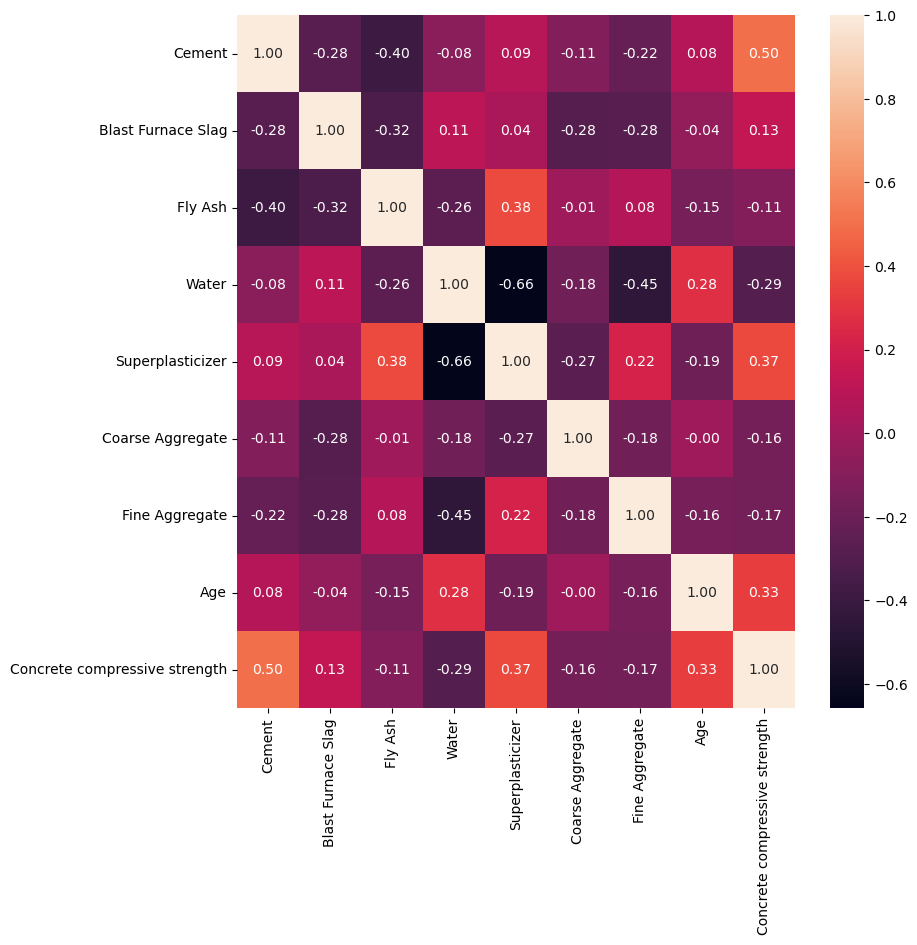

In [136]:
correlation_matrix = comp_strength.corr()

fig, axis = plt.subplots(figsize=(9, 9))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', ax=axis)
plt.show()

Based on the correlation matrix, the features that are selected will be the features that exhibited a high correlation with the target variable, which is concrete compressive strength. Here, the threshold for correlation is |r| > .2.<br> 
Therefore, the attributes that will be used to predict concrete compressive strength are cement, water, superplasticizer, and age.

In [137]:
selected_features = ['Cement', 'Water', 'Superplasticizer', 'Age']
selected_columns = selected_features + ['Concrete compressive strength']
data = comp_strength[selected_columns]

Now that the data is formatted to include only the necessary features, the base data set is created for the models to be trained on.

In [138]:
X = data[['Cement', 'Water', 'Superplasticizer', 'Age']]
y_reg = data['Concrete compressive strength']

Since the action of interest is binary classification, the data labels will be changed to strong and weak, based on whether the concrete compressive strength is above or below the mean, which is 35.

In [139]:
threshold = 35
y = (y_reg >= threshold).astype(int)

**Evaluating Classifier Performance**

The models that will be evaluated on the dataset are the Random Forest, Support Vector Machine (SVM) and Long Short Term Memory (LSTM).

They will be evaluated using 10-fold cross validation.

In [140]:
rf_metrics_list = []
svm_metrics_list = []
lstm_metrics_list = []

kf = KFold(n_splits=10, shuffle=True, random_state=42)
for i, (train_index, test_index) in enumerate(kf.split(X), start=1):
    # Splitting the data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Initialize models
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=None)
    svm_model = SVC(kernel='rbf', C=1.0, random_state=42)
    lstm_model = Sequential([
        Input(shape=(4, 1)),
        LSTM(units=50, activation='tanh', return_sequences=False),
        Dropout(0.2),
        Dense(units=1, activation='sigmoid')
    ])
    lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Reshape data for LSTM
    X_train_lstm = np.expand_dims(X_train.values, axis=2)
    X_test_lstm = np.expand_dims(X_test.values, axis=2)
    
    # Train models
    rf_model.fit(X_train, y_train)
    svm_model.fit(X_train, y_train)
    lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, verbose=0)
    
    # Get predictions
    rf_preds = rf_model.predict(X_test)
    svm_preds = svm_model.predict(X_test)
    lstm_preds = (lstm_model.predict(X_test_lstm) > 0.5).astype(int).flatten()
    
    # Get confusion matrix for each model
    rf_cm = confusion_matrix(y_test, rf_preds)
    svm_cm = confusion_matrix(y_test, svm_preds)
    lstm_cm = confusion_matrix(y_test, lstm_preds)
    
    # Get metrics for each model
    rf_metrics = get_metrics_cm(rf_cm)
    svm_metrics = get_metrics_cm(svm_cm)
    lstm_metrics = get_metrics_cm(lstm_cm)
    
    # Append metrics to their lists for average calculation
    rf_metrics_list.append(rf_metrics)
    svm_metrics_list.append(svm_metrics)
    lstm_metrics_list.append(lstm_metrics)
    
    # Print metrics
    metric_columns = ['TP', 'TN', 'FP', 'FN', 'TPR', 'TNR', 'FPR', 'FNR',
                      'Recall', 'Precision','F1-score', 'Accuracy', 'Error_rate', 
                      'BACC', 'TSS', 'HSS']
    metrics_df = pd.DataFrame([rf_metrics, svm_metrics, lstm_metrics], columns=metric_columns, 
                                  index=['RF','SVM', 'LSTM'])
    print('\n----- Metrics for all Algorithms in Iteration {} -----\n'.format(i))
    print(metrics_df.round(decimals=2).T)
    print('\n')
    

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

----- Metrics for all Algorithms in Iteration 1 -----

               RF    SVM   LSTM
TP          44.00  36.00  32.00
TN          47.00  46.00  48.00
FP           6.00   7.00   5.00
FN           6.00  14.00  18.00
TPR          0.88   0.72   0.64
TNR          0.89   0.87   0.91
FPR          0.11   0.13   0.09
FNR          0.12   0.28   0.36
Recall       0.88   0.72   0.64
Precision    0.88   0.84   0.86
F1-score     0.88   0.77   0.74
Accuracy     0.88   0.80   0.78
Error_rate   0.12   0.20   0.22
BACC         0.88   0.79   0.77
TSS          0.77   0.59   0.55
HSS          0.77   0.59   0.55


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

----- Metrics for all Algorithms in Iteration 2 -----

               RF    SVM   LSTM
TP          51.00  43.00  38.00
TN          48.00  42.00  33.00
FP           1.00   7.00  16.00
FN           3.00  11.00  16.00
TPR          0.94   0.80   0.70
TNR          0.98   0.86   0.67
FPR          0.02   0.14   0.33
FNR       

Now the average metrics for all 10 folds are outputted below.

In [141]:
metric_columns = ['TP', 'TN', 'FP', 'FN', 'TPR', 'TNR', 'FPR', 'FNR',
                      'Recall', 'Precision','F1-score', 'Accuracy', 'Error_rate', 
                      'BACC', 'TSS', 'HSS']
metrics_df = pd.DataFrame([avg_metrics(rf_metrics_list), avg_metrics(svm_metrics_list), avg_metrics(lstm_metrics_list)], columns=metric_columns, 
                              index=['RF','SVM', 'LSTM'])
print('----- Average Metrics for all Algorithms -----\n')
print(metrics_df.round(decimals=2).T)
print('\n')

----- Average Metrics for all Algorithms -----

               RF    SVM   LSTM
TP          44.60  40.20  37.60
TN          47.00  44.20  38.30
FP           5.30   8.10  14.00
FN           6.10  10.50  13.10
TPR          0.88   0.79   0.74
TNR          0.90   0.85   0.74
FPR          0.10   0.15   0.26
FNR          0.12   0.21   0.26
Recall       0.88   0.79   0.74
Precision    0.90   0.83   0.74
F1-score     0.89   0.81   0.73
Accuracy     0.89   0.82   0.74
Error_rate   0.11   0.18   0.26
BACC         0.89   0.82   0.74
TSS          0.78   0.64   0.48
HSS          0.78   0.64   0.47




The ROC (Receiver Operating Characteristic) curve, along with its AUC (Area Under the Curve), is outputted for the Random Forest model below.

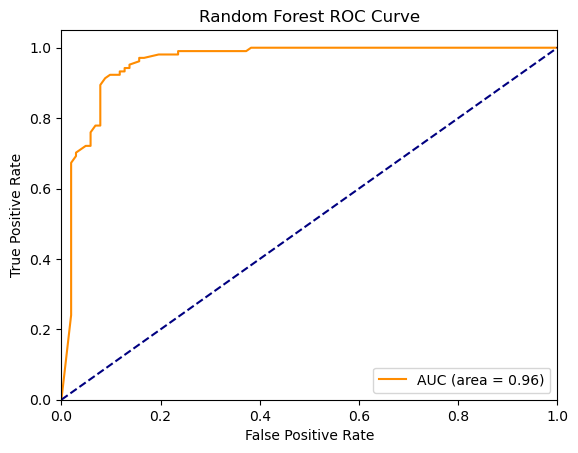

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=None)
rf_model.fit(X_train_scaled, y_train)
y_score_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure()
plt.plot(fpr_rf, tpr_rf, color="darkorange", label="AUC (area = {:.2f})".format(roc_auc_rf))
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest ROC Curve")
plt.legend(loc="lower right")
plt.show()

The ROC curve, along with its AUC, is outputted for the SVM model below.

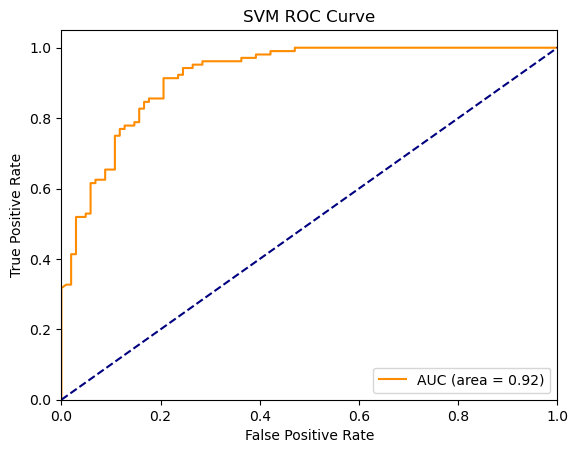

In [149]:
svm_model = SVC(kernel='rbf', C=1.0, random_state=42, probability=True)
svm_model.fit(X_train_scaled, y_train)
y_score_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

fpr_svm, tpr_svm, _ = roc_curve(y_test, y_score_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure()
plt.plot(fpr_svm, tpr_svm, color="darkorange", label="AUC (area = {:.2f})".format(roc_auc_svm))
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SVM ROC Curve")
plt.legend(loc="lower right")
plt.show()

The ROC curve, along with its AUC, is outputted for the LSTM model below.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


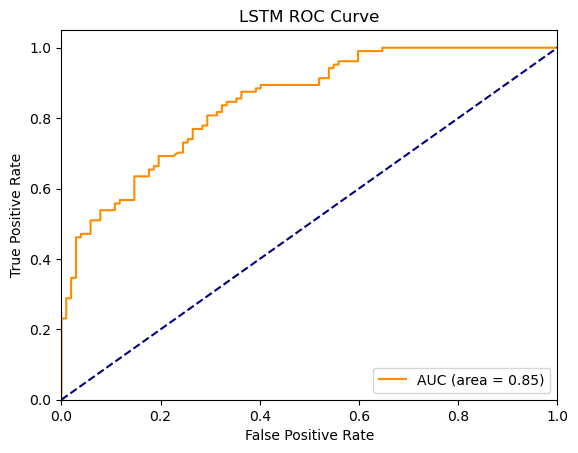

In [150]:
lstm_model = Sequential([
    Input(shape=(4, 1)),
    LSTM(units=50, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(units=1, activation='sigmoid')
])
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

X_train_lstm = np.expand_dims(X_train.values, axis=2)
X_test_lstm = np.expand_dims(X_test.values, axis=2)

lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, verbose=0)
y_score_lstm = lstm_model.predict(X_test_lstm).flatten()

fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_score_lstm)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

plt.figure()
plt.plot(fpr_lstm, tpr_lstm, color="darkorange", label="AUC (area = {:.2f})".format(roc_auc_lstm))
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LSTM ROC Curve")
plt.legend(loc="lower right")
plt.show()

**Deciding Which Algorithm is Best**<br>
For a model to have a good ROC curve, it must closely represent a right angle with the corner at the top left. This implies a maximum true positive rate, which is a desirable outcome for any model.

The **Random Forest** model seems to be the best predictor of concrete compressive strength, due to its high AUC. It also performed the best out of the three models on average for nearly every metric.